# Belgium trains are always late

Belgium trains are always late. That might sounds a bit like a cliché but this is unfortunately confirmed almost every day, especially in Brussels. Usually, I take the train at 8:06 heading to Osteende from Brussels South Station, and I stop in beautiful Ghent where my office is located. I generally show up about 2 min before the scheduled departure time. With no exageration, I can say that my train is systematically delayed by about $8 \pm 5$ min. And it is now freaking cold here in Brussels. So I wait everyday in the Belgium blizzard, fulminating against the Belgium railway company, with only consolation the reading of †he very deep articles from Metronews newspaper.

There is a second stopping in Ghent, scheduled at 8:22 with destination Brugges. I take it from time to time, when I snooze my alarm so many times
that I end up being late. Unfortunately this train isn't much more on time than the one from 8:06. 
While I can not do much against the trains delay, I might  take advantage from the fact that two train are leaving in a row; and try to determine at what time I should arrive in the station such as to wait the least before stepping in a train.

That's the main goal of this post.


## Modelisation of the train departure time

Departure times varies from day to day, so it is quite natural to use a probability distribution to describe this quantity. Idealy, I should use the train delay record of the Belgium company in order to define the shape of the distribution. This dataset are not publicly available, I therefore need to make some hypothesis on the shape of the distribution based on my own experience. 

### Shape of the distribution


It is quite common in the litterature to model phenomena such as departure time of metro with an exponential distribution which is a continuously decreasing on $\mathbb{R}^+$. I think it is not relevant in my situation as, from my experience, the most likely delay is about 8 min. Furthermore, the probabiliy that the train leaves before the scheduled time should be zero.

Let's call A the random variable "departure time of the train to Ostende" and $p_A(t)$ its distribution. 
The simplest choice is thus probably the truncated normal distribution $\mathcal{N}(\mu_A,\sigma_A^2,C_A)$, 
where $C_A$ is the theoretical departure time. The distribution is defined such that :
$$ p_A(t) = \frac{1}{1-F_A(C_A)} \frac{1}{\sigma_A \sqrt{2\pi} }  \text{exp}(- \frac{(t-\mu_A)^2}{2\sigma_A^2}) \ \  \text{for} \ \
t > C_A,$$

and $p_A(t) = 0 \ \ \text{otherwise}$. $F_A( t )$ is the cumulative normal distribution with parameters $(\mu_A,\sigma_A$). 

As I don't have much information, I assume that the random variabme $B$ "departure time of the train to Bruges" also follow the same type of distribution. 

For the numerical implementation in Python, I rescale all the quantities such that $C_A=0$. I use the minute as the unit of time, the numerical values for the parameter are:
- train to Ostende scheduled at 8:06 : $\mu_A=8$, $\sigma_A=5$ and $C_A=0$,
- train to Bruge scheduled at 8:22 : $\mu_B=8$, $\sigma_B=5$ and $C_B=16$ .



Assume that the departure time $t$ of Belgium train are well described by a troncated normal distribution $\mathcal{N}(\mu,\sigma^2,C)$. $C$ is a cutoff parameter which corresponds to the theoretical departure time, meaning that the probability $p(t \le C)=0$. For $t > C$, the distribution is defined by: $$p(t)= \frac{1}{1-F(C)} \frac{1}{\sigma \sqrt{2\pi} }  \text{exp}(- \frac{(t-\mu)^2}{2\sigma^2})$$


I consider two trains say A and B, there is therefore in total 6 parameters and two variables:
- $\mu_A$, $\sigma_A$ and $C_A$ (for train A)
- $\mu_B$, $\sigma_A$ and $C_A$ (for train A)
- the time t
- my arrival time G (as my name is Greghor). Since I want to be sure to get a train, G is bounded $G < C_B$.

From my own experience, Belgium trains are always late. This is unfortunately not a stereotype but the sad truth. The theoretical departure time do not coincide to the mean departure time. I would rather say that trains are generally about $5\pm 3$ min delayed. 
In order to maths a bit easier, I set the origin of time $t=0$ to be equal to the theoretical departure time of train A such that $C_A$=0 and correspondingly rescale all others quantities

(-5, 50)

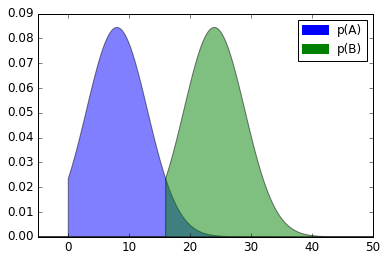

In [28]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.stats import truncnorm
%matplotlib inline


# make fonts larger

mpl.rcParams['xtick.labelsize'] = 12 
mpl.rcParams['ytick.labelsize'] = 12 
mpl.rcParams['axes.labelsize'] = 14 


t=np.arange(-10,1000,0.01)
G=np.arange(-2,14.1,0.1) # my arrival time
waiting=np.zeros(len(G))

## parameters for train A
CminA=0. # theoretical depature time, acts as a cutoff for the distribution
CmaxA=10**4 # upper cutoff, not use
muA=8.
sigA=5.
CminA, CmaxA = (CminA - muA) / sigA, (CmaxA - muA) / sigA # rescale the cutoffs as required by truncom.pdf()

# parameters for train B
CminB=16.
CmaxB=10**4
muB=CminB+muA
sigB=sigA 
CminB, CmaxB = (CminB - muB) / sigB, (CmaxB - muB) / sigB


#build the distributions
pdfA=truncnorm.pdf(t,CminA,CmaxA,loc=muA,scale=sigA)
cdfA=truncnorm.cdf(t,CminA,CmaxA,loc=muA,scale=sigA)
pdfB=truncnorm.pdf(t,CminB,CmaxB,loc=muB,scale=sigB)
cdfB=truncnorm.cdf(t,CminB,CmaxB,loc=muB,scale=sigB)


# Let's check what the distribution looks like


plt.plot([], [], color='blue', linewidth=10)
plt.plot([], [], color='green', linewidth=10)
plt.legend(['p(A)','p(B)'])
plt.fill_between(t,0,pdfA,facecolor='blue',alpha='0.5')
plt.fill_between(t,0,pdfB,facecolor='green',alpha='0.5')

plt.xlim([-5,50])






In [ ]:
#Prealloc
prob_AaftB=np.zeros(len(G))
prob_AbfrB=np.zeros(len(G))
prob_AbfrG=np.zeros(len(G))
prob_AaftG=np.zeros(len(G))
wt_Afirst=np.zeros(len(G))
wt_Bfirst=np.zeros(len(G))

for gi in range(len(G)):
    
    #p(tA < G): train A is gone when G arrives
    prob_AbfrG[gi] = truncnorm.cdf(G[gi],CminA,CmaxA,loc=muA,scale=sigA)
    
    #p(tA>= G): train A is here when I arrived
    prob_AaftG[gi] = 1 - prob_AbfrG[gi]
    
    # waiting time if first train is A given th value of B
    #rescale cutoff
    cutoff= (G[gi] - muA)/sigA
    pdfAgG=truncnorm.pdf(t,cutoff,CmaxA,loc=muA,scale=sigA)
    
    # compute probability that A leaves before B given the value of G
    #evaluate p(tA - tB < 0)
    nbSamp=10**5
    tA=truncnorm.rvs(cutoff,CmaxA,loc=muA,scale=sigA,size=nbSamp)
    tB=truncnorm.rvs(CminB,CmaxB,loc=muB,scale=sigB,size=nbSamp)



    count=np.count_nonzero(tA-tB < 0.)
    prob_AbfrB[gi]=np.float(count)/nbSamp
    prob_AaftB[gi]=1-prob_AbfrB[gi]
    
    
    wt_Afirst[gi]=np.trapz(pdfAgG*(t-G[gi]),t)
    
    #waiting time if first train is B
    wt_Bfirst[gi]=np.trapz(pdfB*(t-G[gi]),t)
    
    # mean waitinh time
    waiting[gi]=prob_AaftG[gi]*(prob_AbfrB[gi]*wt_Afirst[gi] + prob_AaftB[gi]*wt_Bfirst[gi]) + prob_AbfrG[gi]*wt_Bfirst[gi]
    #waiting[gi]=np.trapz((t-G[gi])*())
    
    
prob_A=prob_AaftG*prob_AbfrB
prob_B=(prob_AaftG*prob_AaftB+prob_AbfrG)

toto=np.zeros(len(G))

for gi in range(len(G)):
    
    toto[gi]=np.trapz(pdfB*(t-G[gi]),t)
    


In [ ]:
#prob to take train A against train B
plt.plot(G,prob_A,G,prob_B,G,prob_A+prob_B)
plt.ylim([0,1.1])
plt.xlim([np.min(G),np.max(G)+10])
plt.grid()
plt.legend(["probA","probB","probA+probB"],loc=5)

In [ ]:
# prob of firt departure given G
plt.plot(G,prob_AbfrB,G,prob_AaftB,G,prob_AbfrB+prob_AaftB)
plt.ylim([0, 1.1])

In [ ]:
%matplotlib qt
plt.plot(G,prob_A*wt_Afirst,G,prob_B*wt_Bfirst,G,prob_A*wt_Afirst+prob_B*wt_Bfirst)

In [ ]:
%matplotlib inline
plt.plot(G,prob_A*wt_Afirst,G,prob_B*wt_Bfirst,G,prob_A*wt_Afirst+prob_B*wt_Bfirst)

In [ ]:
tA=truncnorm.rvs(CminA,CmaxA,loc=muA,scale=sigA,size=10**6)
tB=truncnorm.rvs(CminB,CmaxB,loc=muB,scale=sigB,size=10**6)

plt.hist(tA-tB,bins=100);

In [ ]:
plt.plot(G,wt_Afirst,G,wt_Bfirst)

In [ ]:
plt.plot(G,prob_AaftG)
plt.xlim([-2.,5.])

In [ ]:
0.7*0.8+0.3*24

In [ ]:
truncnorm.cdf(-1.1,CminA,CmaxA,loc=muA,scale=sigA)

In [ ]:
CminA


In [ ]:
G[waiting==np.min(waiting)]

In [ ]:
plt.plot(G,prob_A,G,prob_B)

In [ ]:
truncnorm.cdf(t,CminA,CmaxA,loc=muA,scale=5)

In [ ]:
%matplotlib inline
plt.plot(t,truncnorm.cdf(t,CminA,CmaxA,loc=muA,scale=10))
plt.xlim([-5 , 10])

In [ ]:
CminA
